Resources:

1. [towards ds 10 min bin classifier](https://towardsdatascience.com/10-minutes-to-building-a-binary-image-classifier-by-applying-transfer-learning-to-mobilenet-eab5a8719525)
2. [tf tutorial on transfer learning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [11]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_dir = pathlib.Path(train_dir)
validation_dir = pathlib.Path(validation_dir)

In [4]:
TOTAL_NUMBER_OF_SAMPLES = tf.data.Dataset.list_files(str(train_dir/'*/*')).cardinality().numpy()

In [5]:
list_train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=False)
list_validation_ds = tf.data.Dataset.list_files(str(validation_dir/'*/*'), shuffle=False)


def parse_image(fname):
    parts = tf.strings.split(fname, os.sep)
    class_label = parts[-2]
    image = tf.io.read_file(fname)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image, class_label

train_ds = list_train_ds.map(parse_image).batch(BATCH_SIZE)
validation_ds = list_validation_ds.map(parse_image).batch(BATCH_SIZE)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet"
)

# gw_model

In [8]:
def pca_reduce(features):
    features = features.reshape(features.shape[0], np.prod(features.shape[1:]))
    pca = PCA(n_components=256)
    pca.fit(features)
    Y = pca.transform(features)
    return Y


def k_means(pca_features):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(reduced_features)
    return kmeans.labels_

In [9]:
import tqdm

In [1]:
def recompute_labels():
    all_features = np.empty((TOTAL_NUMBER_OF_SAMPLES, 5,5,1280))
    index = 0
    for i, (batch, labels) in tqdm.tqdm(enumerate(train_ds)):
        all_features[i*batch.shape[0]:(i+1)*batch.shape[0], :, :, :] = base_model(batch)
    reduced_features = pca_reduce(all_features)
    new_labels = k_means(reduced_features)
    data = [img for imgs, labels in list(train_ds) for img in imgs]
    data = tf.data.Dataset.from_tensor_slices(data)
    labels = tf.data.Dataset.from_tensor_slices(new_labels)
    return tf.data.Dataset.zip((data, labels)).batch(BATCH_SIZE)

In [ ]:
for img, label in ds.take(1):
    print(img.shape, label)

In [ ]:
recompute_labels()

32it [00:47,  1.39s/it]

In [ ]:
data = [imgs for imgs, labels in list(train_ds)]
tf.data.Dataset.zip(data, new_labels)

In [ ]:

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

hidden_layer = tf.keras.layers.Dense(10)
prediction_batch = hidden_layer(feature_batch_average)

prediction_layer = tf.keras.layers.Dense(4)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [144]:
imgs, lables = list(train_ds)[0]

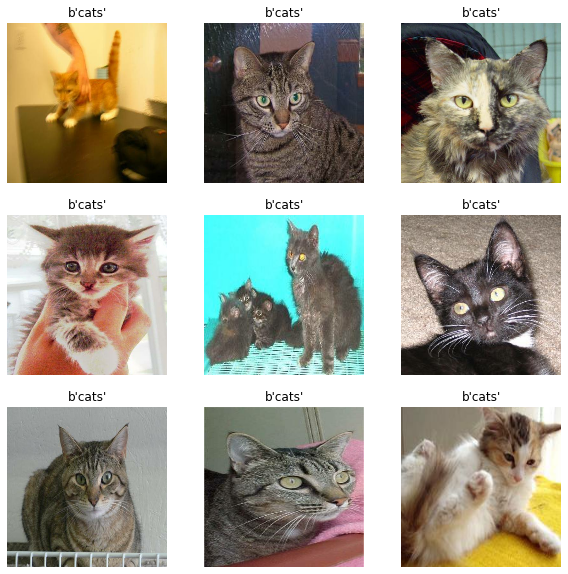

In [126]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i].numpy())
        plt.axis('off')

In [233]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [235]:
initial_epochs = 10

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
63/63 [==============================] - 42s 646ms/step - loss: 1.9786 - accuracy: 0.2290 - val_loss: 1.6056 - val_accuracy: 0.2900
Epoch 2/10
63/63 [==============================] - 43s 681ms/step - loss: 1.7292 - accuracy: 0.2971 - val_loss: 1.5090 - val_accuracy: 0.3350
Epoch 3/10
63/63 [==============================] - 43s 684ms/step - loss: 1.5237 - accuracy: 0.3515 - val_loss: 1.3539 - val_accuracy: 0.3730
Epoch 4/10
63/63 [==============================] - 53s 838ms/step - loss: 1.4572 - accuracy: 0.3831 - val_loss: 1.2688 - val_accuracy: 0.4310
Epoch 5/10
63/63 [==============================] - 60s 954ms/step - loss: 1.3418 - accuracy: 0.4058 - val_loss: 1.2183 - val_accuracy: 0.4680
Epoch 6/10
63/63 [==============================] - 43s 684ms/step - loss: 1.2866 - accuracy: 0.4561 - val_loss: 1.1443 - val_accuracy: 0.4970
Epoch 7/10
63/63 [==============================] - 57s 909ms/step - loss: 1.2530 - accuracy: 0.4543 - val_loss: 1.1309 - val_accuracy: 0.4990

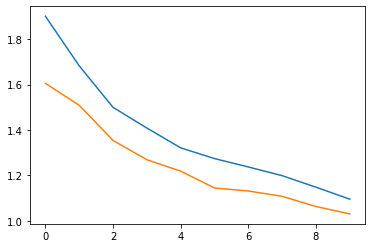

In [236]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

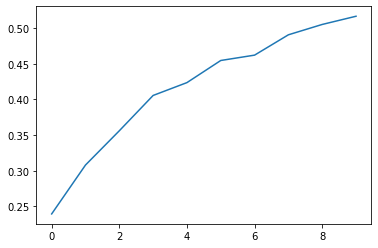

In [237]:
plt.plot(history.history['accuracy'])

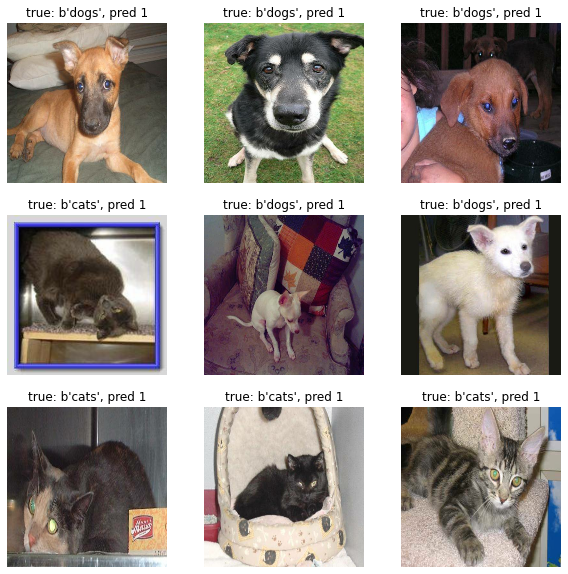

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    predictions = model.predict_on_batch(images)
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.math.argmax(predictions, axis=1)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'true: {labels[i].numpy()}, pred {predictions[i].numpy()}')
        plt.axis('off')
